pixel_values 전체 shape: torch.Size([1, 4, 3, 224, 224])
첫 번째 배치의 patches shape: torch.Size([4, 3, 224, 224])


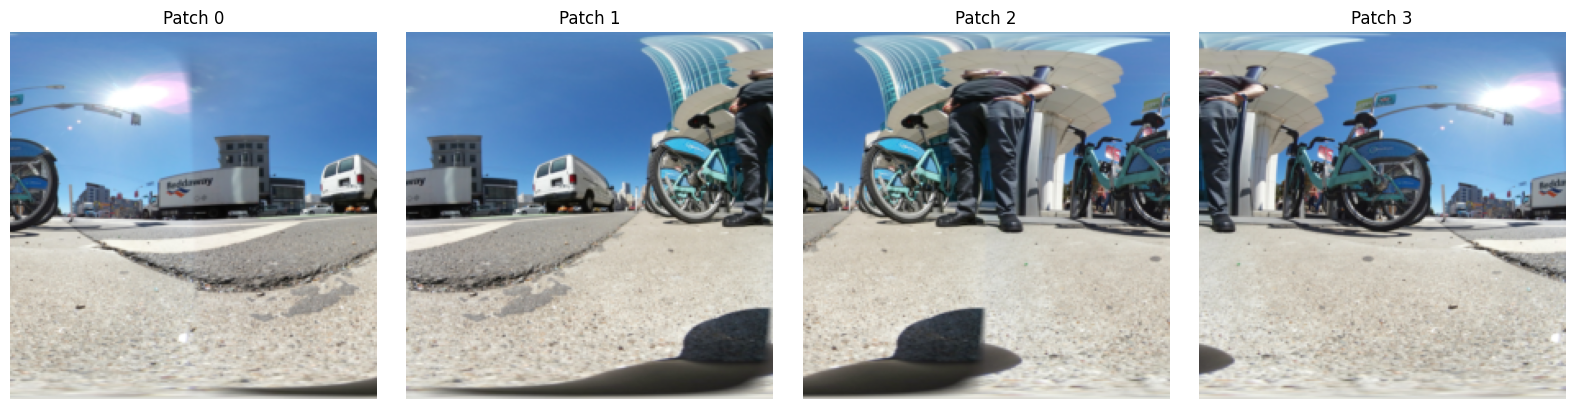

In [3]:
import torch
from datasets import load_dataset
from PIL import Image
import requests
from io import BytesIO
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

# 데이터 로드
ds = load_dataset(
    "csv",
    data_files={
        "train": "data/raw/QuIC360/train.csv",
        "valid": "data/raw/QuIC360/valid.csv",
        "test": "data/raw/QuIC360/test.csv"
    }
)       # ds["train","valid","test"][0] : {"url": "https://...jpg", "query": "...", "annotation", "..."}

PATCH_SIZE = 224
STRIDE     = PATCH_SIZE // 2
to_tensor  = T.ToTensor()

def transform_batch(batch):
    all_batch_pixel_values = []  # 배치의 모든 이미지에 대한 패치들을 저장
    
    for url in batch["url"]:
        image_pixel_values = []  # 현재 이미지의 패치들을 저장
        
        # 1) 이미지 다운로드
        resp = requests.get(url)
        img = Image.open(BytesIO(resp.content)).convert("RGB")

        # 2) 리사이즈 (height 고정)
        w, h = img.size
        new_h = PATCH_SIZE
        new_w = int(w * (new_h / h))
        img_r = img.resize((new_w, new_h), Image.BILINEAR)

        # 3) 슬라이딩 크롭
        for x in range(0, new_w - PATCH_SIZE + 1, STRIDE):
            patch = img_r.crop((x, 0, x + PATCH_SIZE, PATCH_SIZE))
            image_pixel_values.append(to_tensor(patch))

        # 4) 래핑 패치 (끝과 처음 50%)
        last = img_r.crop((new_w - STRIDE, 0, new_w, PATCH_SIZE))
        first = img_r.crop((0, 0, STRIDE, PATCH_SIZE))
        wrap = Image.new("RGB", (PATCH_SIZE, PATCH_SIZE))
        wrap.paste(last, (0, 0))
        wrap.paste(first, (STRIDE, 0))
        image_pixel_values.append(to_tensor(wrap))
        
        # 현재 이미지의 모든 패치를 스택하여 저장
        all_batch_pixel_values.append(torch.stack(image_pixel_values))
    
    # 배치의 모든 이미지 패치를 스택
    batch["pixel_values"] = torch.stack(all_batch_pixel_values)
    
    return batch

# 실시간 transform 설정
ds = ds.with_transform(transform_batch)

# DataLoader (batch_size=1)
loader = DataLoader(ds["train"], batch_size=1)

# 한 배치 시각화
batch = next(iter(loader))
patches = batch["pixel_values"][0]  # 첫 번째 배치의 모든 패치, shape: [패치수, 3, 224, 224]
print("pixel_values 전체 shape:", batch["pixel_values"].shape)
print("첫 번째 배치의 patches shape:", patches.shape)
num_patches = patches.size(0)

plt.figure(figsize=(4 * num_patches, 4))
for i in range(num_patches):
    ax = plt.subplot(1, num_patches, i + 1)
    
    img = patches[i].permute(1, 2, 0).cpu().numpy()  # (224,224,3)
    ax.imshow(img)
    ax.set_title(f"Patch {i}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [10]:
from datasets import load_dataset

ds = load_dataset(
    "csv",
    data_files={
        "train": "data/raw/QuIC360/train.csv",
        # "validation": "data/raw/QuIC360/valid.csv",
        # "test": "data/raw/QuIC360/test.csv"
    }
)

In [ ]:
print(ds["train"]["url"][0])
print(ds["train"]["query"][0])
print(ds["train"]["annotation"][0])


https://live.staticflickr.com/8380/29237818512_ebfa8f5d04_f.jpg
street
This is a sidewalk near a large intersection in a commercial district of a city.  There are large trucks, a bus, and several cars waiting at a red traffic light.


In [6]:
print(ds["test_refer"]["url"][0])
print(ds["test_refer"]["query"][0])
print(ds["test_refer"]["annotation"][0])

refer360images/indoor/living_room/pano_aaeavjzaxfgowq.jpg
furniture
The furniture of the room is well organized and it is made by wood, there have the chairs and table


In [ ]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration

# 1. 모델·프로세서 로드
# model_name = "Salesforce/blip2-flan-t5-xl"
model_name = "Salesforce/blip2-opt-2.7b"

CACHE_PATH = ".cache"  # 원하는 상대/절대 경로
if CACHE_PATH:
    import os
    os.makedirs(CACHE_PATH, exist_ok=True)
processor = Blip2Processor.from_pretrained(
    model_name,
    cache_dir=CACHE_PATH,
    device_map="auto"
)
model = Blip2ForConditionalGeneration.from_pretrained(
    model_name,
    cache_dir=CACHE_PATH,
    device_map="auto"
)

# 2. 개별 모듈 분리
vision_encoder = model.vision_model      # 이미지 인코더
qformer        = model.qformer          # Q-Former 모듈
language_projector = model.language_projection  # 언어 프로젝터
language_model  = model.language_model  # 언어 모델


# (선택) 각 모듈 요약 정보 출력
print("Processor config:", processor.config)
# print("Vision Encoder:", vision_encoder.config)
# print("Q-Former:",        qformer.config)
# print("Language Projector:", language_model.config)

c:\Users\Seungwoo\.conda\envs\surr\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from PIL import Image
import requests
# 3. 이미지와 질문을 프로세서에 넣어 인코딩
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

question = "how many dogs are in the picture?"
inputs = processor(raw_image, question, return_tensors="pt")
print("inputs:", type(inputs))
out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

inputs: <class 'transformers.image_processing_base.BatchFeature'>
one


In [3]:
processor

Blip2Processor:
- image_processor: BlipImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "BlipImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "Blip2Processor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

- tokenizer: T5TokenizerFast(name_or_path='Salesforce/blip2-flan-t5-xl', vocab_size=32100, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', 

In [25]:
print(processor.image_processor)
print(processor.tokenizer)
print(processor.chat_template)

BlipImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "BlipImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "Blip2Processor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

T5TokenizerFast(name_or_path='Salesforce/blip2-flan-t5-xl', vocab_size=32100, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>